In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load Data
df = pd.read_csv("loan_approval_data.csv")


In [ ]:
# Understanding Dataset
df.head()
df.info()
df.isnull().sum()
df.describe()

In [3]:
# Remove Applicant Id as it dsnt contribute to model training and drop null loan approved rows as they dsnt provide correct info
df = df.drop("Applicant_ID", axis=1)
df = df.dropna(subset=["Loan_Approved"])


In [4]:
#Encoding Target value
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df["Loan_Approved"] = le_target.fit_transform(df["Loan_Approved"])

# Check
print(df["Loan_Approved"].value_counts())

Loan_Approved
0    652
1    298
Name: count, dtype: int64


In [5]:
# Handle missing values
from sklearn.impute import SimpleImputer

categorical_cols = [
    "Employment_Status",
    "Marital_Status",
    "Loan_Purpose",
    "Property_Area",
    "Education_Level",
    "Gender",
    "Employer_Category"
]


numerical_cols = [
    col for col in df.select_dtypes(include=["number"]).columns
    if col != "Loan_Approved"
]
num_imp = SimpleImputer(strategy="mean")
df[numerical_cols] = num_imp.fit_transform(df[numerical_cols])

cat_imp = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imp.fit_transform(df[categorical_cols])


In [ ]:
print(num_imp.feature_names_in_)
print(cat_imp.feature_names_in_)
df.isnull().sum()

Text(0.5, 1.0, 'Is Loan Approved Or Not?')

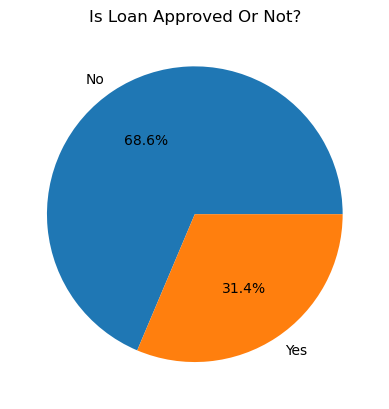

In [48]:
# EDA - Exploratory Data Analysis

# 1. How balanced our classes are?
classes_count = df["Loan_Approved"].value_counts()
plt.pie(classes_count , labels = ["No", "Yes"], autopct="%1.1f%%")
plt.title("Is Loan Approved Or Not?")

# --> Classes are not that balanced

In [ ]:
# 2. Analyze Categories
#gender_cnt = df["Gender"].value_counts()
#ax = sns.barplot(gender_cnt)
#ax.bar_label(ax.containers[0])

loan_purpose_cnt = df["Loan_Purpose"].value_counts()
ax = sns.barplot(loan_purpose_cnt)
ax.bar_label(ax.containers[0])

edu_cnt = df["Education_Level"].value_counts()
ax = sns.barplot(edu_cnt)
ax.bar_label(ax.containers[0])
plt.tight_layout()

# --> understood the distribution of loan_costumers on various cols

<Axes: xlabel='Applicant_Income', ylabel='Count'>

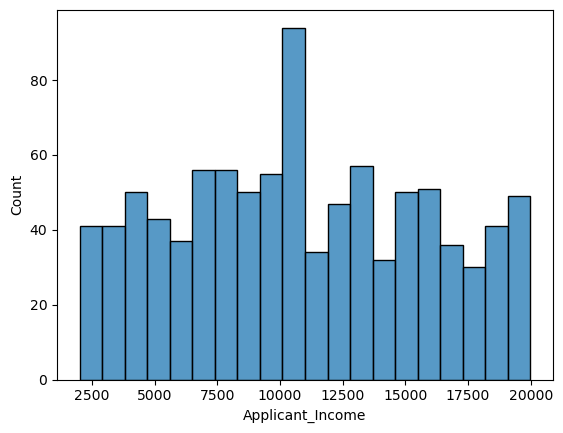

In [49]:
# 3. Analyze Income ( Imp Features )

sns.histplot(
    data = df,
    x = "Applicant_Income",
    bins=20
)


In [ ]:
sns.histplot(
    data = df,
    x = "Coapplicant_Income",
    bins=20
)
# --> income of applicant and coapplicant has same variation

<Axes: xlabel='Loan_Approved', ylabel='Applicant_Income'>

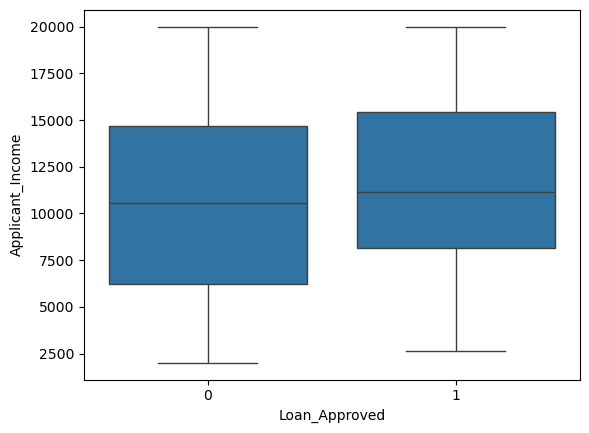

In [50]:
# 4. Outliers
sns.boxplot(
    data=df,
    x="Loan_Approved",
    y="Applicant_Income"
)

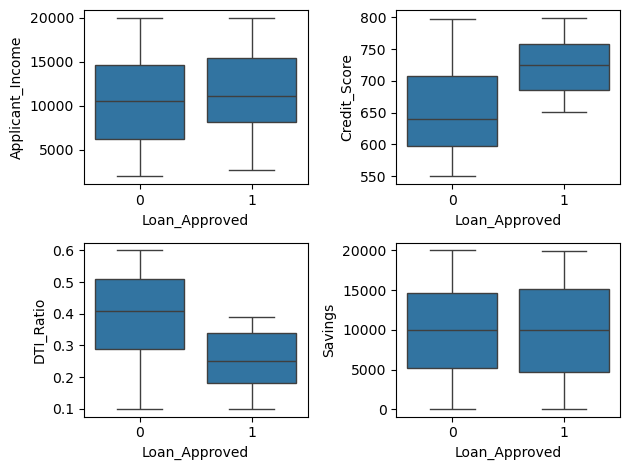

In [51]:
fig, axes = plt.subplots(2, 2)

sns.boxplot(ax=axes[0, 0], data=df, x="Loan_Approved",y="Applicant_Income")
sns.boxplot(ax=axes[0, 1], data=df, x="Loan_Approved",y="Credit_Score")
sns.boxplot(ax=axes[1, 0], data=df, x="Loan_Approved",y="DTI_Ratio")
sns.boxplot(ax=axes[1, 1], data=df, x="Loan_Approved",y="Savings")

plt.tight_layout()

# --> we have no such outliers to remove or keep

<Axes: xlabel='Credit_Score', ylabel='Count'>

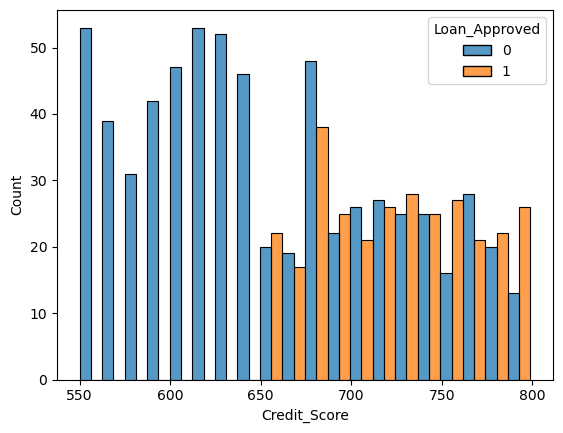

In [52]:
# Loan approval comparasion rate with different features
# Credit Score with Loan Approval
sns.histplot(
    data=df,
    x="Credit_Score",
    hue="Loan_Approved",
    bins=20,
    multiple="dodge"
)

<Axes: xlabel='Applicant_Income', ylabel='Count'>

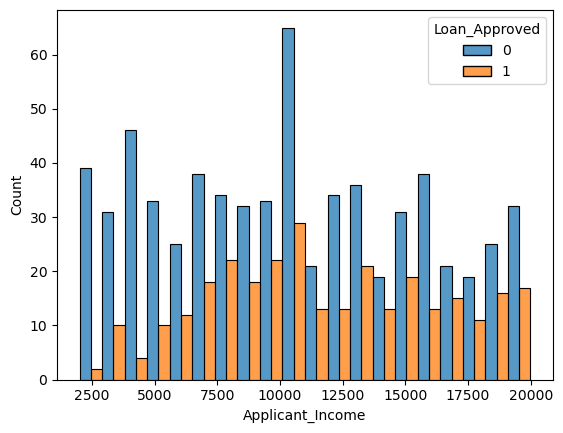

In [53]:
sns.histplot(
    data=df,
    x="Applicant_Income",
    hue="Loan_Approved",
    bins=20,
    multiple="dodge"
)

<Axes: xlabel='Loan_Amount', ylabel='Count'>

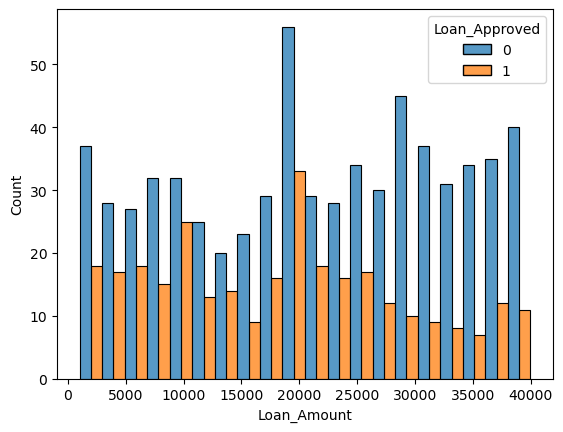

In [54]:
sns.histplot(
    data=df,
    x="Loan_Amount",
    hue="Loan_Approved",
    bins=20,
    multiple="dodge"
)

In [ ]:

sns.histplot(
    data=df,
    x="Employer_Category",
    hue="Loan_Approved",
    bins=20,
    multiple="dodge"
)

In [6]:
# Encoding other features
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding 
le_edu = LabelEncoder()
df["Education_Level"] = le_edu.fit_transform(df["Education_Level"])

le_target = LabelEncoder()
df["Loan_Approved"] = le_target.fit_transform(df["Loan_Approved"])

# One-Hot Encoding 
ohe_cols = [
    "Employment_Status",
    "Marital_Status",
    "Loan_Purpose",
    "Property_Area",
    "Gender",
    "Employer_Category"
]

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded = ohe.fit_transform(df[ohe_cols])

# -------------------------------
# SAVE CATEGORIES FROM OHE (BEST WAY)
# -------------------------------
category_values = {
    col: list(cats)
    for col, cats in zip(ohe.feature_names_in_, ohe.categories_)
}

import pickle
pickle.dump(category_values, open("category_values.pkl", "wb"))


encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(ohe_cols),
    index=df.index
)

df = pd.concat([df.drop(columns=ohe_cols), encoded_df], axis=1)


In [ ]:
# All preprocessing done
df.head()


<Axes: >

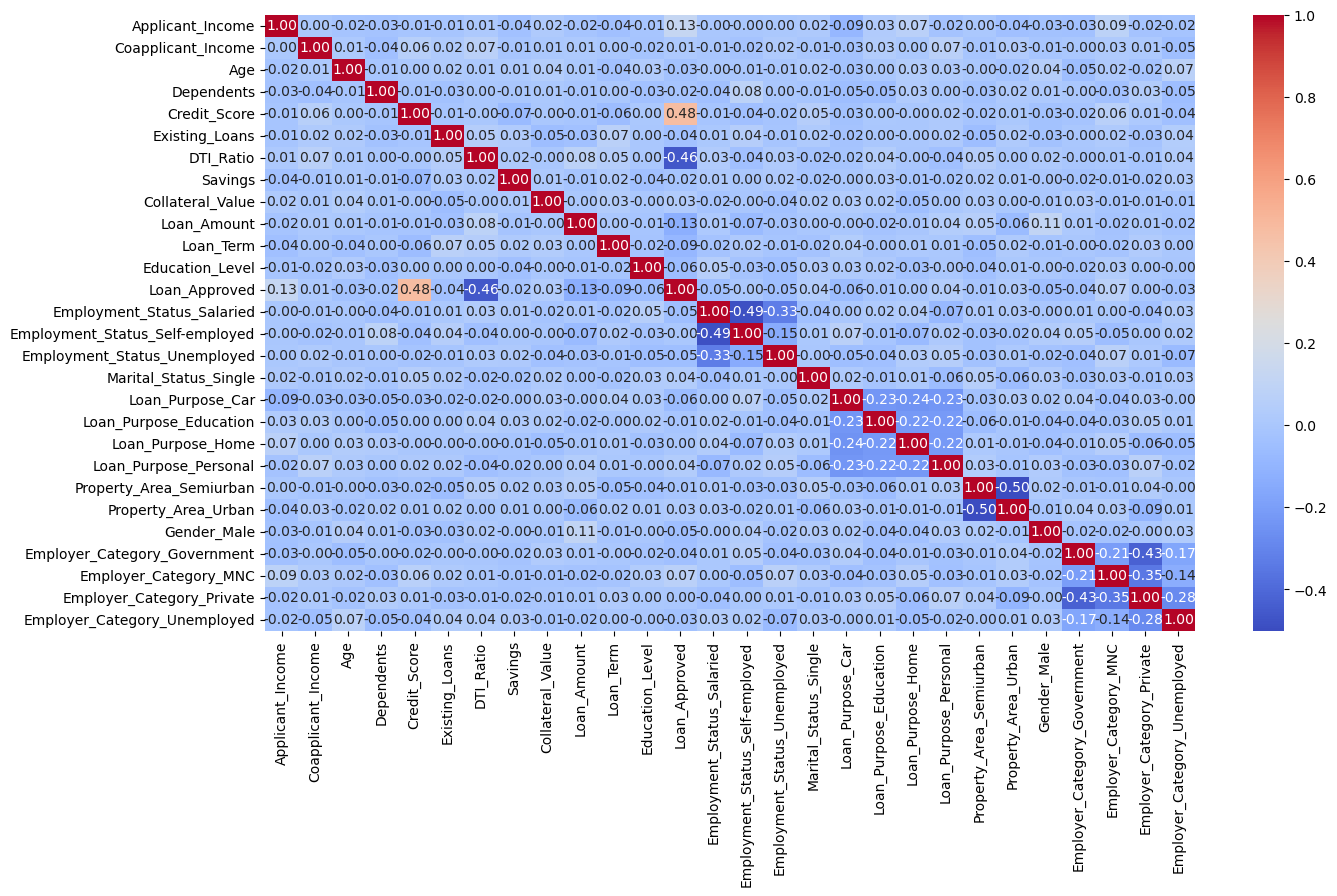

In [8]:
# Correlation Heatmap

num_cols = df.select_dtypes(include="number")
corr_matrix = num_cols.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
#--> No such co-relation / linear relation found suggests linear model may not work great with this data set

In [ ]:
num_cols.corr()["Loan_Approved"].sort_values(ascending=False)
# Tells correlation of all features with loan approved , to identify imp features, helps in feature selection and detects multicollinearity

In [38]:
# Train-Test Split And Feature Scaling

X = df.drop("Loan_Approved", axis=1)
y = df["Loan_Approved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Train and Evaluate
# Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Logistic Regression Model
Precision:  0.864406779661017
Recall:  0.8360655737704918
F1 score:  0.85
Accuracy:  0.9052631578947369
CM:  [[121   8]
 [ 10  51]]


In [40]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

# Evaluation
print("KNN Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

KNN Model
Precision:  0.803921568627451
Recall:  0.6721311475409836
F1 score:  0.7321428571428571
Accuracy:  0.8421052631578947
CM:  [[119  10]
 [ 20  41]]


In [41]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)

# Evaluation
print("Naive Bayes Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Naive Bayes Model
Precision:  0.9047619047619048
Recall:  0.9344262295081968
F1 score:  0.9193548387096774
Accuracy:  0.9473684210526315
CM:  [[123   6]
 [  4  57]]


# Selected model on basis of precision -> NAIVE BAYES

In [42]:
# Feature Engineering

# Add or Tranform features
df["DTI_Ratio_sq"] = df["DTI_Ratio"] ** 2
df["Credit_Score_sq"] = df["Credit_Score"] ** 2

# df["Applicant_Income_log"] = np.log1p(df["Applicant_Income"])

X = df.drop(columns=["Loan_Approved", "Credit_Score", "DTI_Ratio"])
y = df["Loan_Approved"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Evaluation after feature engineering

# Logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

y_pred = log_model.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Logistic Regression Model
Precision:  0.8596491228070176
Recall:  0.8032786885245902
F1 score:  0.8305084745762712
Accuracy:  0.8947368421052632
CM:  [[121   8]
 [ 12  49]]


In [44]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

# Evaluation
print("KNN Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

KNN Model
Precision:  0.7441860465116279
Recall:  0.5245901639344263
F1 score:  0.6153846153846154
Accuracy:  0.7894736842105263
CM:  [[118  11]
 [ 29  32]]


In [45]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)

# Evaluation
print("Naive Bayes Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Naive Bayes Model
Precision:  0.9019607843137255
Recall:  0.7540983606557377
F1 score:  0.8214285714285714
Accuracy:  0.8947368421052632
CM:  [[124   5]
 [ 15  46]]


In [46]:
from sklearn.naive_bayes import BernoulliNB
nb_model_ = BernoulliNB()
nb_model_.fit(X_train_scaled, y_train)

y_pred = nb_model_.predict(X_test_scaled)

# Evaluation
print("Naive Bayes Bernoulli Model")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Naive Bayes Bernoulli Model
Precision:  0.8846153846153846
Recall:  0.7540983606557377
F1 score:  0.8141592920353983
Accuracy:  0.8894736842105263
CM:  [[123   6]
 [ 15  46]]


In [47]:
# After scaling (feature enggineering) no great improvement in models is seen
# Among all the models naive bayes without feature eng. performed best..
# As we want minimum false positive in priority  and it is fulfilling this need (90%) 

FINAL MODEL CHOOSED FOR CREDI_SURE -> NAIVE BAYES 

Precision:  90.4 % , 
Recall:  93.4 % , 
F1 score: 91.9 % , 
Accuracy:  94.7 % , 
False Positive: 6 , 
False Negative: 4

In [ ]:
# Streamlit artifacts
import pickle

pickle.dump(num_imp, open("num_imputer.pkl", "wb"))
pickle.dump(cat_imp, open("cat_imputer.pkl", "wb"))

pickle.dump(le_edu, open("le_education.pkl", "wb"))
pickle.dump(le_target, open("le_target.pkl", "wb")) 
pickle.dump(ohe, open("onehot_encoder.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(nb_model, open("model.pkl", "wb"))

pickle.dump(
    X.columns.tolist(),
    open("features.pkl", "wb")
)
